<a href="https://colab.research.google.com/github/BassemMagdi0007/Sentiment-analysis/blob/main/Models/%20Sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##cleaning

In [ ]:
!pip install pyarabic

In [ ]:
!pip install dtale

  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import dtale
import dtale.app as dtale_app

dtale_app.USE_COLAB = True

In [ ]:
!git clone https://github.com/iabufarha/ArSarcasm.git

In [ ]:
!unrar e '/content/sentiment paper with DataSet.rar' 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/sentiment paper with DataSet.rar

Extracting  40000-Egyptian-tweets.xlsx                                    66%  OK 
Extracting  Deep learning approaches for Arabic sentiment analysis.pdf      99%  OK 
All OK


In [ ]:
import json
import pandas as pd
import html
import logging
import re
import pyarabic.araby as araby

In [ ]:
train_sarcasm = pd.read_csv("/content/ArSarcasm/dataset/ArSarcasm_train.csv")
test_sarcasm = pd.read_csv("/content/ArSarcasm/dataset/ArSarcasm_test.csv")

sarcasm_df = pd.concat([train_sarcasm[['tweet','original_sentiment']],test_sarcasm[['tweet','original_sentiment']]],ignore_index=True)
sarcasm_df.rename(columns={"tweet":"text","original_sentiment":"label"},inplace=True)

In [ ]:
mazajk_df = pd.read_excel("/content/40000-Egyptian-tweets.xlsx")
mazajk_df.columns = ['text','label']

In [ ]:
url_regexes = [
    r"(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)",
    r"@(https?|ftp)://(-\.)?([^\s/?\.#-]+\.?)+(/[^\s]*)?$@iS",
    r"http[s]?://[a-zA-Z0-9_\-./~\?=%&]+",
    r"www[a-zA-Z0-9_\-?=%&/.~]+",
    r"[a-zA-Z]+\.com",
    r"(?=http)[^\s]+",
    r"(?=www)[^\s]+",
    r"://",
]

user_mention_regex = r"@[\w\d]+"
email_regexes = [r"[\w-]+@([\w-]+\.)+[\w-]+", r"\S+@\S+"]
redundant_punct_pattern = (
    r"([!\"#\$%\'\(\)\*\+,\.:;\-<=·>?@\[\\\]\^_ـ`{\|}~—٪’،؟`୍“؛”ۚ【»؛\s+«–…‘]{2,})"
)
regex_tatweel = r"(\D)\1{2,}"
rejected_chars_regex = r"[^0-9\a-zA-Z\[\]!\"#\$%\'\(\)\*\+,\.:;\-<=·>?@\[\\\]\^_ـ`{\|}~—٪’،؟`୍“؛”ۚ»؛\s+«–…‘]"

regex_url_step1 = r"(?=http)[^\s]+"
regex_url_step2 = r"(?=www)[^\s]+"
regex_url = r"(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
regex_mention = r"@[\w\d]+"
regex_email = r"\S+@\S+"

chars_regex = r"0-9\u0621-\u063A\u0640-\u066C\u0671-\u0674a-zA-Z\[\]!\"#\$%\'\(\)\*\+,\.:;\-<=·>?@\[\\\]\^_ـ`{\|}~—٪’،؟`୍“؛”ۚ»؛\s+«–…‘"

white_spaced_double_quotation_regex = r'\"\s+([^"]+)\s+\"'
white_spaced_single_quotation_regex = r"\'\s+([^']+)\s+\'"
white_spaced_back_quotation_regex = r"\`\s+([^`]+)\s+\`"
white_spaced_em_dash = r"\—\s+([^—]+)\s+\—"

left_spaced_chars = r" ([\]!#\$%\),\.:;\?}٪’،؟”؛…»·])"
right_spaced_chars = r"([\[\(\{“«‘*\~]) "
left_and_right_spaced_chars = r" ([\+\-\<\=\>\@\\\^\_\|\–]) "
replace_urls_emails_mentions=True
strip_tashkeel=True
strip_tatweel=True
insert_white_spaces=True
remove_elongation=True
remove_html_markup=True


def preprocess(text):
    """
    Preprocess takes an input text line an applies the same preprocessing used in AraBERT
                        pretraining
    Args:
        text (:obj:`str`): inout text string
    Returns:
        string: A preprocessed string depending on which model was selected
    """


    text = str(text)
    text = html.unescape(text)
    if strip_tashkeel:
        text = araby.strip_tashkeel(text)
    if strip_tatweel:
        text = araby.strip_tatweel(text)

    if replace_urls_emails_mentions:
        # replace all possible URLs
        for reg in url_regexes:
            text = re.sub(reg, " [رابط] ", text)
        # REplace Emails with [بريد]
        for reg in email_regexes:
            text = re.sub(reg, " [بريد] ", text)
        # replace mentions with [مستخدم]
        text = re.sub(user_mention_regex, " [مستخدم] ", text)        

    if remove_html_markup:
        # remove html line breaks
        text = re.sub("<br />", " ", text)
        # remove html markup
        text = re.sub("</?[^>]+>", " ", text)

    # remove repeated characters >2
    if remove_elongation:
        text = _remove_elongation(text)

    # insert whitespace before and after all non Arabic digits or English Digits and Alphabet and the 2 brackets
    if insert_white_spaces:
        text = re.sub(
            "([^0-9\u0621-\u063A\u0641-\u064A\u0660-\u0669a-zA-Z\[\]])",
            r" \1 ",
            text,
        )

        # insert whitespace between words and numbers or numbers and words
        text = re.sub(
            "(\d+)([\u0621-\u063A\u0641-\u064A\u0660-\u066C]+)", r" \1 \2 ", text
        )
        text = re.sub(
            "([\u0621-\u063A\u0641-\u064A\u0660-\u066C]+)(\d+)", r" \1 \2 ", text
        )


    # text = re.sub(rejected_chars_regex, " ", text)

    # remove extra spaces
    text = " ".join(text.replace("\uFE0F", "").split())

    # ALl the other models dont require Farasa Segmentation
    text = re.sub(r"[a-zA-Z]+", " ",text)
    text = re.sub("\d+","",text)
    text = re.sub("[┊┊•°°•´¸•´¨¸•¨¸•]"," ",text)
    text = re.sub("[ŁÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßïîíìëêéèçæåäãâáàðñòóôõöøùúûüýþÿďĎčČċĊĉĈćĆąĄăĂāĀĐđĒēĔĕĖėĘęĚěĜĝĞğįĭĬīĪĩĨħĦĥĤģĢġĠİıĲĳĴĵĶķĸĹĺĻļĽľĿŏŎōŌŋŊŉňņŅńŃłŁŀŐőŒœŔŕŖŗŘřŚśŜŝŞşůŮŭŬūŪũŨŧŦťŤţšŠŰűŲųŴŵŶŷŸŹźŻżŽžſ]"," ", text)
    text = re.sub(r'[[\]]+', " ", text)

    return text



def _remove_elongation(text):
    """
    :param text:  the input text to remove elongation
    :return: delongated text
    """
    # loop over the number of times the regex matched the text
    for index_ in range(len(re.findall(regex_tatweel, text))):
        elongation = re.search(regex_tatweel, text)
        if elongation:
            elongation_pattern = elongation.group()
            elongation_replacement = elongation_pattern[0]
            elongation_pattern = re.escape(elongation_pattern)
            text = re.sub(
                elongation_pattern, elongation_replacement, text, flags=re.MULTILINE
            )
        else:
            break
    return text

def _remove_redundant_punct(text):
    text_ = text
    result = re.search(redundant_punct_pattern, text)
    dif = 0
    while result:
        sub = result.group()
        sub = sorted(set(sub), key=sub.index)
        sub = " " + "".join(list(sub)) + " "
        text = "".join(
            (text[: result.span()[0] + dif], sub, text[result.span()[1] + dif :])
        )
        text_ = "".join(
            (text_[: result.span()[0]], text_[result.span()[1] :])
        ).strip()
        dif = abs(len(text) - len(text_))
        result = re.search(redundant_punct_pattern, text_)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [ ]:
# map = {
#   '(:' : '🙂',
#   ':)' : '🙂',
#   ':-)': '🙂',
#   '=)' : '🙂',
#   '):' : '☹️',
#   ':(' : '☹️',
#   ':-(': '☹️',
#   '=(' : '☹️',
#   ':"(': '😢',
#   ":'(": '😢',
#   ':D' : '😄',
#   'D:' : '😄',
#   '^_^': '😄',
#   ':P' : '😛',
#   ';)' : '😉'
# }
# def replace_with(Found_Emoji):
#   Found_Emoji = Found_Emoji.group(0)
#   emoji = " "+map[Found_Emoji]+" "
#   return emoji

# def replace(sentence):
#   result = re.sub(r"\(:|:\)|:-\)|=\)|\):|:\(|:-\(|=\(|:\"\(|:'\(|:D|D:|\^_\^|:P|;\)",replace_with, sentence)
#   return result

# all_train_data.text = all_train_data.text.apply(replace)
# test.Text = test.Text.apply(replace)

In [ ]:
#Apply the cleaning
sarcasm_df.text= sarcasm_df.text.apply(preprocess)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: FutureWarning:

Possible nested set at position 1



In [ ]:
#Replacing conditions
sarcasm_df.text = sarcasm_df.apply(lambda x : re.sub(r'"',"",x['text']),axis=1)
sarcasm_df.text = sarcasm_df.apply(lambda x : re.sub(r"[#]+"," هاشتاج ",x['text']),axis=1)
sarcasm_df.text = sarcasm_df.apply(lambda x : re.sub(r"[_|-|:|.|(|)|—]+"," ",x['text']),axis=1)

In [ ]:
dtale.show(sarcasm_df)

https://urka2jsg67h-496ff2e9c6d22116-40000-colab.googleusercontent.com/dtale/main/3

In [ ]:
all_data = pd.concat([sarcasm_df,mazajk_df],ignore_index=True)

In [ ]:
all_data.label = all_data.label.map({"negative":"Negative","positive":"Positive","neutral":"Neutral"}.get)
all_data.label.value_counts()


Negative    24061
Positive    22553
Neutral      3926
Name: label, dtype: int64

In [ ]:
all_data.to_csv("CLeaned_data.csv",index=False)

##Imports

In [ ]:
!nvidia-smi

Wed May 19 04:55:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers
# !pip install dtale

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments,AutoTokenizer
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import seaborn as sns
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForMaskedLM

# import dtale
# import dtale.app as dtale_app

# dtale_app.USE_COLAB = True
from tokenizers import Tokenizer
from tqdm import tqdm_notebook
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn import metrics
from pprint import pprint
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os, sys
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk.corpus import names
import nltk


import numpy as np
import pandas as pd
import os
import time
import gc
import random
import torch
from IPython.display import HTML


nltk.download('names')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re 
from nltk.corpus import stopwords

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
pip install kornia

In [ ]:
model_name = ['UBC-NLP/MARBERT','cardiffnlp/twitter-xlm-roberta-base','aubmindlab/bert-base-arabertv02']

In [ ]:
# bert = AutoModel.from_pretrained('UBC-NLP/MARBERT')

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name[0])

##Model

In [ ]:
train = pd.read_csv("/content/CLeaned_data.csv")
train.columns = ['text','sentiment']
train.dropna(inplace=True)

In [ ]:
train.sentiment.value_counts()

Negative    24061
Positive    22553
Neutral      3926
Name: sentiment, dtype: int64

In [ ]:
class_name = ['Negative','Positive','Neutral']
train.sentiment = train.sentiment.map({'Negative':0,'Positive':1,"Neutral":2})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train.sentiment.value_counts()

0    24061
1    22553
2     3926
Name: sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MAX LENGTH:  120


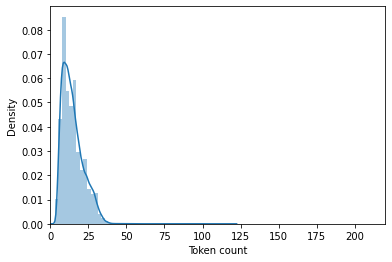

In [ ]:
import matplotlib.pyplot as plt

token_lens = []
for txt in train.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 220]);
plt.xlabel('Token count');
print("MAX LENGTH: ",max(token_lens))

In [ ]:
MAX_LEN = max(token_lens)

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(
  train,
  test_size=0.3,
  random_state= np.random.seed(1234),
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state= np.random.seed(1234),
)

In [ ]:
print(len(df_train))
print(len(df_val))
print(len(df_test))

35378
7581
7581


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True
  )

def create_test_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
  )

In [ ]:
def create_loader(BATCH_SIZE):

  train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
  test_data_loader = create_test_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

  return train_data_loader,val_data_loader, test_data_loader

In [ ]:
PRE_TRAINED_MODEL_NAME= model_name[0]

In [ ]:
## BERT With MLP

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes,drop_value):
    super(SentimentClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=drop_value)
    self.out = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 50),
            nn.ReLU(),
            nn.Linear(50, n_classes)
        )

  def forward(self, input_ids, attention_mask):
    dect_= self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(dect_['pooler_output'])
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_name),0.3)
model = model.to(device)

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import kornia
from  kornia import losses

In [ ]:
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

from kornia.utils.one_hot import one_hot


def linear_combination(x, y):
  smoothing = 0.1
  return smoothing * x + (1 - smoothing) * y


def reduce_loss(loss):
  reduction = 'mean'
  return loss.mean() if reduction == 'mean' else loss.sum() \
    if reduction == 'sum' else loss


def focal_loss(
        input: torch.Tensor,
        target: torch.Tensor,
        alpha: float,
        gamma: float = 2.0,
        reduction: str = 'none',
        eps: float = 1e-8) -> torch.Tensor:

    if not isinstance(input, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) >= 2:
        raise ValueError("Invalid input shape, we expect BxCx*. Got: {}"
                         .format(input.shape))

    if input.size(0) != target.size(0):
        raise ValueError('Expected input batch_size ({}) to match target batch_size ({}).'
                         .format(input.size(0), target.size(0)))

    n = input.size(0)
    num_classes=input.shape[1]
    out_size = (n,) + input.size()[2:]
    if target.size()[1:] != input.size()[2:]:
        raise ValueError('Expected target size {}, got {}'.format(
            out_size, target.size()))

    if not input.device == target.device:
        raise ValueError(
            "input and target must be in the same device. Got: {} and {}" .format(
                input.device, target.device))

    # compute softmax over the classes axis
    input_soft: torch.Tensor = F.softmax(input, dim=1) + eps

    loss_soft = reduce_loss(-input_soft.sum(dim=-1))
    # create the labels one hot tensor
    target_one_hot: torch.Tensor = one_hot(
        target, num_classes=input.shape[1],
        device=input.device, dtype=input.dtype)

    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1., gamma)

    focal = -alpha * weight * torch.log(input_soft)
    loss_tmp = torch.sum(target_one_hot * focal, dim=1)
    if reduction == 'none':
        loss = loss_tmp
    elif reduction == 'mean':
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError("Invalid reduction mode: {}"
                                  .format(reduction))
    return linear_combination(loss_soft / num_classes, loss)


class FocalLoss(nn.Module):

    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none', eps: float = 1e-8) -> None:
        super(FocalLoss, self).__init__()
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.reduction: str = reduction
        self.eps: float = eps

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps)

In [ ]:
def optimization(learning_rate,EPOCHS,model,train_data_loader,num_warmup_steps):

  optimizer = AdamW(model.parameters(),lr=learning_rate ,correct_bias=True)
  total_steps = len(train_data_loader) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = num_warmup_steps,
    num_training_steps=total_steps
  )
  loss_fn = FocalLoss(alpha=0.5, gamma=2.0, reduction='mean')

  return optimizer, scheduler, loss_fn

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# # Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
# sweep_config = {
#     'method': 'bayes', #grid, random
#     'metric': {
#       'name': 'Val loss',
#       'goal': 'minimize'   
#     },

#     'early_terminate':{
#     'type': 'hyperband',
#     'max_iter': 3
#     },
#     'parameters': {
#         'epochs': {
#             'values': [2, 4, 5]
#         },
#         'dropout': {
#             'values': [0.3, 0.4, 0.5]
#         },

#         'learning_rate': {
#             'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5,2e-5]
#         },
#          'BATCH_SIZE': {
#             'values': [16, 32,64]
#         },
#         'num_warmup_steps':{
#           'values':[2,5,8]  
#         },
#     }
# }

In [ ]:
# sweep_id = wandb.sweep(sweep_config, entity="alymostafa", project="sentiment_kaggle")

## Training 

In [ ]:
def run_epochs():
  history = defaultdict(list)
  best_accuracy = 0

  config_defaults = {
  'epochs': 2,
  'BATCH_SIZE': 16,
  'learning_rate': 1e-5,
  'dropout':0.3,
  'num_warmup_steps' : 5,
  'seed': 42
  }
  # wandb.init(config=config_defaults)

  # config = wandb.config

  model = SentimentClassifier(len(class_name),config_defaults['dropout'])
  model = model.to(device)
  

  train_data_loader, val_data_loader, test_data_loader = create_loader(config_defaults['BATCH_SIZE'])

  optimizer,scheduler, loss_fn =  optimization(config_defaults['learning_rate'], config_defaults['epochs'],model,train_data_loader,config_defaults['num_warmup_steps'])

  for epoch in tqdm_notebook(range(config_defaults['epochs'])):
    # print(f'Epoch {epoch + 1}/{config_defaults.epochs}')
    # print('-' * 10)
    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
    )
    # wandb.log({"Train loss": train_loss})
    # wandb.log({"train_accuracy": train_acc})
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
    )
    # wandb.log({"Val loss": val_loss})
    # wandb.log({"val_accuracy": val_acc})
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc
    
  return model, train_data_loader, val_data_loader, test_data_loader, optimizer, scheduler, loss_fn

In [ ]:
model, train_data_loader, val_data_loader, test_data_loader, optimizer, scheduler, loss_fn = run_epochs()

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebo

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 0.029859310075822564 accuracy 0.8370456215727289
Val loss 0.010611221198196904 accuracy 0.8777206173328056

Train loss -0.0009752053567031516 accuracy 0.9231160608287636
Val loss 0.016251638814618316 accuracy 0.8820736050652948




## Prediction

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.881018335311964

In [ ]:
from tqdm import tqdm_notebook
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in tqdm_notebook(data_loader):
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs,real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

    Negative       0.89      0.91      0.90      3608
    Positive       0.91      0.88      0.89      3370
     Neutral       0.69      0.70      0.70       603

    accuracy                           0.88      7581
   macro avg       0.83      0.83      0.83      7581
weighted avg       0.88      0.88      0.88      7581



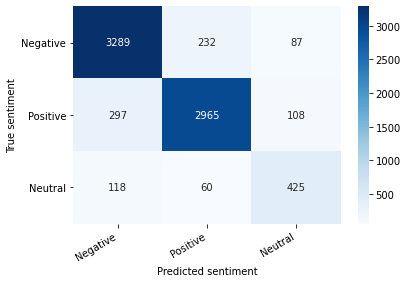

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [ ]:

# test = pd.read_csv('/content/test_version3_1.csv')
# dashboard_nostopwords.rename(columns={"Text":"text"},inplace=True)
# dashboard_nostopwords['sentiment'] = 0
# dashboard_nostopwords['prob'] = 0
# dashboard_nostopwords['all_prob'] = 0
# test_dash_no_stopwords = create_test_data_loader(dashboard_nostopwords, tokenizer, MAX_LEN, 16)

# y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
#   model,
#   test_dash_no_stopwords,
# )

# dashboard_nostopwords['sentiment'] = y_pred.numpy().tolist() 


# m = nn.Softmax(dim=1)
# soft_prob = m(y_pred_probs)
# prob_list = [i.max().item() for i in soft_prob]
# dashboard_nostopwords['prob'] = prob_list

# prob_list_lamo = [i for i in soft_prob]
# dashboard_nostopwords['all_prob'] = prob_list_lamo


# dashboard_nostopwords.sentiment = dashboard_nostopwords.sentiment.apply({1:"Positive", 0:'Negative', 2:"Neutral"}.get)

#interpretability

In [ ]:
pip install transformers-interpret


In [ ]:
# model = SentimentClassifier(3,0.3)
# model = model.to(device)
# optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=True)

In [ ]:
# output_model ="/content/best_model_state.bin"
# checkpoint = torch.load(output_model, map_location='cuda')
# model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
import transformers_interpret

In [ ]:
transformers_interpret.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# With both the model and tokenizer initialized we are now able to get explanations on an example text.
from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)


Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at U

In [ ]:
test_data_loader.dataset.reviews


array(['في غيبوبة للاسف .الحالة خطرة جدا . ',
       'براحة علينا شوية انت هتزعق ولا ايه .',
       'انا اقول حبيتك لله فى لله كدا ليه  . ', ...,
       ' كلب إسرائيل وسيفها الإرهابي بوتن قاتل النساء والأطفال ظهرت حقيقته الإجرامية الحاقدة ، وكل الدول تقف معه قلبا وقلباوتعمل على بقاء السفاح بشار ',
       'حتى عندنا كان النت مقطوع . ',
       ' مستخدم  مبروك عليك ويندوز      ربنا يخلهولك'], dtype=object)

In [ ]:
word_attributions = cls_explainer(' نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما كنا متوقعين الله يرحم ايامات السيقا والفاميلي  هاشتاج    ')


In [ ]:
cls_explainer.predicted_class_name

'LABEL_0'

In [ ]:
word_attributions

[('[CLS]', 0.0),
 ('نصيحه', 0.09549759213309242),
 ('ما', -0.11287902801754987),
 ('عمرك', -0.10628086275928474),
 ('اتن', -0.18388401355838951),
 ('##زل', -0.20045502410336885),
 ('لعبة', -0.15244458456325946),
 ('سوبر', -0.1332822718344345),
 ('ماريو', -0.06277850367995111),
 ('مش', -0.21473116663450326),
 ('زي', 0.045846259803347514),
 ('ما', 0.09794286836566347),
 ('كنا', 0.35117183694875614),
 ('متوقعين', -0.43745736793306184),
 ('الله', 0.09330164467724644),
 ('يرحم', -0.11480477841198355),
 ('اياما', -0.33617346695795625),
 ('##ت', -0.32120857566684874),
 ('السي', -0.16175598941687083),
 ('##قا', -0.04268723150762631),
 ('والفا', -0.38331541097925376),
 ('##ميلي', -0.06414343970975489),
 ('هاشتاج', 0.24145967650082775),
 ('[SEP]', 0.0)]

In [ ]:
train['text'][0]

' نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما كنا متوقعين الله يرحم ايامات السيقا والفاميلي  هاشتاج    '

In [ ]:
cls_explainer.visualize("distilbert_viz.html")
